In [1]:
# ===================================================================
# BLOQUE 1: PREPARACIÓN COMPLETA DE DATOS
# ===================================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# --- Carga de Datos y Feature Engineering ---
df = pd.read_csv('Students_Data.csv')
df.dropna(axis=0, inplace=True)
print("Iniciando Ingeniería de Características...")
intereses_map = {
    "C": [1, 12, 20, 53, 64, 71, 78, 85, 91, 98], 
    "H": [9, 25, 34, 41, 56, 67, 74, 80, 89, 95],
    "A": [3, 11, 21, 28, 36, 45, 50, 57, 81, 96], 
    "S": [8, 16, 23, 33, 44, 52, 62, 70, 87, 92],
    "I": [6, 19, 27, 38, 47, 54, 60, 75, 83, 97], 
    "D": [5, 14, 24, 31, 37, 48, 58, 65, 73, 84],
    "E": [17, 32, 35, 42, 49, 61, 68, 77, 88, 93]
}
aptitudes_map = {
    "C": [2, 15, 46, 51], 
    "H": [30, 63, 72, 86], 
    "A": [22, 39, 76, 82],
    "S": [4, 29, 40, 69], 
    "I": [10, 26, 59, 90],
    "D": [13, 18, 43, 66],
    "E": [7, 55, 79, 94]
}
columnas_preguntas = df.columns[0:98]
df_scores_interes = pd.DataFrame()
for area, preguntas_nums in intereses_map.items():
    cols_a_sumar = columnas_preguntas[[num - 1 for num in preguntas_nums]]
    df_scores_interes[f'puntaje_interes_{area}'] = df[cols_a_sumar].sum(axis=1)
df_scores_aptitud = pd.DataFrame()
for area, preguntas_nums in aptitudes_map.items():
    cols_a_sumar = columnas_preguntas[[num - 1 for num in preguntas_nums]]
    df_scores_aptitud[f'puntaje_aptitud_{area}'] = df[cols_a_sumar].sum(axis=1)
def calcular_deltas(row):
    puntajes_ordenados = sorted(row, reverse=True)
    if len(puntajes_ordenados) < 3: return 0, 0
    return puntajes_ordenados[0] - puntajes_ordenados[1], puntajes_ordenados[1] - puntajes_ordenados[2]
deltas_interes = df_scores_interes.apply(calcular_deltas, axis=1, result_type='expand')
df_scores_interes['delta_interes_1_2'] = deltas_interes[0]
df_scores_interes['delta_interes_2_3'] = deltas_interes[1]
deltas_aptitud = df_scores_aptitud.apply(calcular_deltas, axis=1, result_type='expand')
df_scores_aptitud['delta_aptitud_1_2'] = deltas_aptitud[0]
df_scores_aptitud['delta_aptitud_2_3'] = deltas_aptitud[1]
X_enriquecido = pd.concat([
    df[columnas_preguntas].reset_index(drop=True),
    df_scores_interes[['delta_interes_1_2', 'delta_interes_2_3']].reset_index(drop=True),
    df_scores_aptitud[['delta_aptitud_1_2', 'delta_aptitud_2_3']].reset_index(drop=True)
], axis=1)
X = X_enriquecido
target_columns = [
    'perfil_interes_1_nombre', 
    'perfil_interes_2_nombre', 
    'perfil_aptitud_1_nombre', 
    'perfil_aptitud_2_nombre'

    # 'carrera_interes_1', 
    # 'carrera_interes_2', 
    # 'carrera_interes_3', 
    # 'carrera_interes_4',
    # 'carrera_interes_5',
    # 'carrera_aptitud_1', 
    # 'carrera_aptitud_2', 
    # 'carrera_aptitud_3', 
    # 'carrera_aptitud_4', 
    # 'carrera_aptitud_5'
]
Y_textual = df[target_columns].copy()
Y_codificado = pd.DataFrame()
encoders = {}
for col in Y_textual.columns:
    le = LabelEncoder()
    Y_codificado[col] = le.fit_transform(Y_textual[col])
    encoders[col] = le
print("Variables X e Y listas.")

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y_codificado, test_size=0.2, random_state=42
)
print("Datos divididos en entrenamiento y prueba.")
print("✅ Datos divididos en conjuntos de entrenamiento y prueba.")
print(f"Dimensiones de X_train: {X_train.shape}, Dimensiones de Y_train: {Y_train.shape}")
print(f"Dimensiones de X_train: {X_test.shape}, Dimensiones de Y_train: {Y_test.shape}")

Iniciando Ingeniería de Características...
Variables X e Y listas.
Datos divididos en entrenamiento y prueba.
✅ Datos divididos en conjuntos de entrenamiento y prueba.
Dimensiones de X_train: (431, 102), Dimensiones de Y_train: (431, 4)
Dimensiones de X_train: (108, 102), Dimensiones de Y_train: (108, 4)


In [2]:
# ===================================================================
# BÚSQUEDA ÓPTIMA CON SVM Y CLASSIFIERCHAIN
# ===================================================================
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.multioutput import ClassifierChain
from sklearn.model_selection import RandomizedSearchCV
from skmultilearn.model_selection import IterativeStratification
from scipy.stats import expon, uniform
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score

# ==================== 1. DEFINICIÓN DE SCORERS PERSONALIZADOS ===================
# (Se mantienen las mismas funciones de métricas que ya tenías)
def average_f1_scorer(y_true, y_pred):
    if isinstance(y_true, pd.DataFrame): y_true = y_true.to_numpy()
    if isinstance(y_pred, pd.DataFrame): y_pred = y_pred.to_numpy()
    return np.mean([f1_score(y_true[:, i], y_pred[:, i], average='weighted', zero_division=0) for i in range(y_true.shape[1])])

def average_accuracy_scorer(y_true, y_pred):
    if isinstance(y_true, pd.DataFrame): y_true = y_true.to_numpy()
    if isinstance(y_pred, pd.DataFrame): y_pred = y_pred.to_numpy()
    return np.mean([accuracy_score(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])])

def average_precision_scorer(y_true, y_pred):
    if isinstance(y_true, pd.DataFrame): y_true = y_true.to_numpy()
    if isinstance(y_pred, pd.DataFrame): y_pred = y_pred.to_numpy()
    return np.mean([precision_score(y_true[:, i], y_pred[:, i], average='weighted', zero_division=0) for i in range(y_true.shape[1])])

def average_recall_scorer(y_true, y_pred):
    if isinstance(y_true, pd.DataFrame): y_true = y_true.to_numpy()
    if isinstance(y_pred, pd.DataFrame): y_pred = y_pred.to_numpy()
    return np.mean([recall_score(y_true[:, i], y_pred[:, i], average='weighted', zero_division=0) for i in range(y_true.shape[1])])

scoring_metrics = {
    'f1': make_scorer(average_f1_scorer),
    'accuracy': make_scorer(average_accuracy_scorer),
    'precision': make_scorer(average_precision_scorer),
    'recall': make_scorer(average_recall_scorer)
}

# ==================== 2. CONFIGURACIÓN DE LA BÚSQUEDA PARA SVM ===================
# Se reemplaza XGBClassifier por SVC y se le añade 'probability=True'
# para que pueda ser usado consistentemente en el ClassifierChain.
svm_estimator = SVC(probability=True, random_state=42)

# Se mantiene ClassifierChain, pero ahora con el estimador SVC.
chain_model = ClassifierChain(base_estimator=svm_estimator, random_state=42)

# *** AJUSTE CLAVE ***:
# Nuevos hiperparámetros específicos para la optimización de SVM.
param_distributions = {
    'base_estimator__C': expon(scale=100),              # Explora valores de C en una distribución exponencial.
    'base_estimator__gamma': expon(scale=.1),           # Explora valores de gamma.
    'base_estimator__kernel': ['rbf', 'poly'],          # Prueba con los kernels más comunes.
    'base_estimator__degree': [2, 3]                    # Grado del polinomio (solo para kernel='poly').
}

iterative_stratification = IterativeStratification(n_splits=3, order=1)

random_search_svm = RandomizedSearchCV(
    estimator=chain_model,
    param_distributions=param_distributions,
    n_iter=30,
    scoring=scoring_metrics,
    refit='f1',
    cv=iterative_stratification,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=False
)

print("--- Iniciando Búsqueda Avanzada con SVM y Métricas Múltiples ---")
random_search_svm.fit(X_train, Y_train)

# ==================== 3. MUESTRA DE RESULTADOS DETALLADOS ====================
print("\n✅ ¡Búsqueda con SVM completada con éxito!")
print("="*60)
print("La mejor combinación de hiperparámetros (optimizada por F1) es:")
print(random_search_svm.best_params_)

best_index_svm = random_search_svm.best_index_
results_svm = random_search_svm.cv_results_

print("\n--- Métricas del Mejor Modelo SVM (obtenidas con validación cruzada) ---")
print(f"  - F1-Score Promedio:      {results_svm['mean_test_f1'][best_index_svm]:.4f}")
print(f"  - Accuracy Promedio:      {results_svm['mean_test_accuracy'][best_index_svm]:.4f}")
print(f"  - Precisión Promedio:     {results_svm['mean_test_precision'][best_index_svm]:.4f}")
print(f"  - Recall Promedio:        {results_svm['mean_test_recall'][best_index_svm]:.4f}")
print("="*60)

--- Iniciando Búsqueda Avanzada con SVM y Métricas Múltiples ---
Fitting 3 folds for each of 30 candidates, totalling 90 fits

✅ ¡Búsqueda con SVM completada con éxito!
La mejor combinación de hiperparámetros (optimizada por F1) es:
{'base_estimator__C': 46.92680899768591, 'base_estimator__degree': 2, 'base_estimator__gamma': 0.02026485043181491, 'base_estimator__kernel': 'poly'}

--- Métricas del Mejor Modelo SVM (obtenidas con validación cruzada) ---
  - F1-Score Promedio:      0.5429
  - Accuracy Promedio:      0.5528
  - Precisión Promedio:     0.5721
  - Recall Promedio:        0.5528


In [3]:
# ===================================================================
# BLOQUE DE PREDICCIÓN Y MÉTRICAS CON EL MODELO SVM OPTIMIZADO
# ===================================================================
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import numpy as np

# 1. Obtener el MEJOR modelo SVM de la búsqueda
final_svm_model = random_search_svm.best_estimator_

# 2. Realizar predicciones en el conjunto de prueba
y_pred_svm = final_svm_model.predict(X_test)

# 3. Convertir las predicciones a un DataFrame
y_pred_svm_df = pd.DataFrame(y_pred_svm, columns=Y_test.columns, index=Y_test.index)

print("✅ Predicciones con SVM generadas correctamente.")
print("-" * 50)

# --- Calcular y Mostrar Métricas Detalladas ---
exact_match_accuracy_svm = np.mean((Y_test.values == y_pred_svm_df.values).all(axis=1))
accuracy_list_svm = []
f1_list_svm = []
precision_list_svm = []
recall_list_svm = []

print("--- Métricas por Etiqueta (Label-based) con SVM ---")
for col_name in Y_test.columns:
    acc = accuracy_score(Y_test[col_name], y_pred_svm_df[col_name])
    prec = precision_score(Y_test[col_name], y_pred_svm_df[col_name], average='weighted', zero_division=0)
    rec = recall_score(Y_test[col_name], y_pred_svm_df[col_name], average='weighted', zero_division=0)
    f1 = f1_score(Y_test[col_name], y_pred_svm_df[col_name], average='weighted', zero_division=0)
    
    accuracy_list_svm.append(acc)
    f1_list_svm.append(f1)
    precision_list_svm.append(prec)
    recall_list_svm.append(rec)
    
    print(f"  - {col_name}:  Accuracy={acc:.3f}, F1-Score={f1:.3f}")

print("\n--- Métricas Promedio del Modelo SVM ---")
print(f"🎯 Precisión Exacta (Exact Match): {exact_match_accuracy_svm:.4f} ({exact_match_accuracy_svm * 100:.2f}%)")
print(f"Accuracy Promedio:              {np.mean(accuracy_list_svm):.4f}")
print(f"F1-Score Promedio (Weighted):   {np.mean(f1_list_svm):.4f}")
print(f"Precisión Promedio (Weighted):  {np.mean(precision_list_svm):.4f}")
print(f"Recall Promedio (Weighted):     {np.mean(recall_list_svm):.4f}")
print("=" * 50)

✅ Predicciones con SVM generadas correctamente.
--------------------------------------------------
--- Métricas por Etiqueta (Label-based) con SVM ---
  - perfil_interes_1_nombre:  Accuracy=0.741, F1-Score=0.733
  - perfil_interes_2_nombre:  Accuracy=0.407, F1-Score=0.420
  - perfil_aptitud_1_nombre:  Accuracy=0.741, F1-Score=0.719
  - perfil_aptitud_2_nombre:  Accuracy=0.565, F1-Score=0.555

--- Métricas Promedio del Modelo SVM ---
🎯 Precisión Exacta (Exact Match): 0.1667 (16.67%)
Accuracy Promedio:              0.6134
F1-Score Promedio (Weighted):   0.6067
Precisión Promedio (Weighted):  0.6285
Recall Promedio (Weighted):     0.6134


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curves(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Genera una gráfica de las curvas de aprendizaje para un estimador dado.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.set_title(title, fontsize=16, fontname='Times New Roman')
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples", fontsize=12, fontname='Times New Roman')
    ax.set_ylabel("Score (Accuracy)", fontsize=12, fontname='Times New Roman')

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="b")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="r")
    
    ax.plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="r", label="Cross-validation score")

    ax.legend(loc="best", fontsize=12)
    return plt

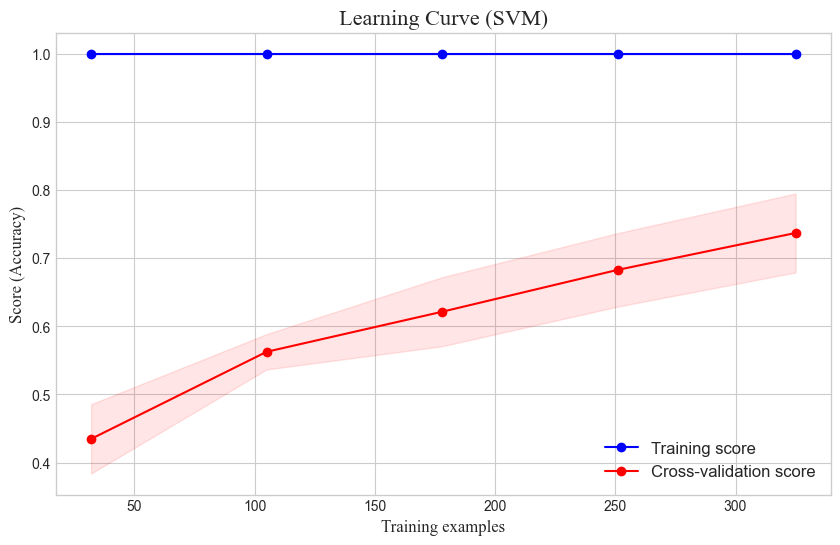

In [10]:
from sklearn.svm import SVC

# Usa los mejores parámetros de tu notebook SVM-Model.ipynb
best_params_svm = {'C': 97.63, 'kernel': 'rbf', 'gamma': 0.01, 'degree': 3}
svm_model = SVC(random_state=42, probability=True, **best_params_svm)

# Graficamos usando la primera etiqueta como ejemplo
plot_learning_curves(svm_model, "Learning Curve (SVM)", X_train, Y_train.iloc[:, 0], cv=5, n_jobs=-1)
plt.show()

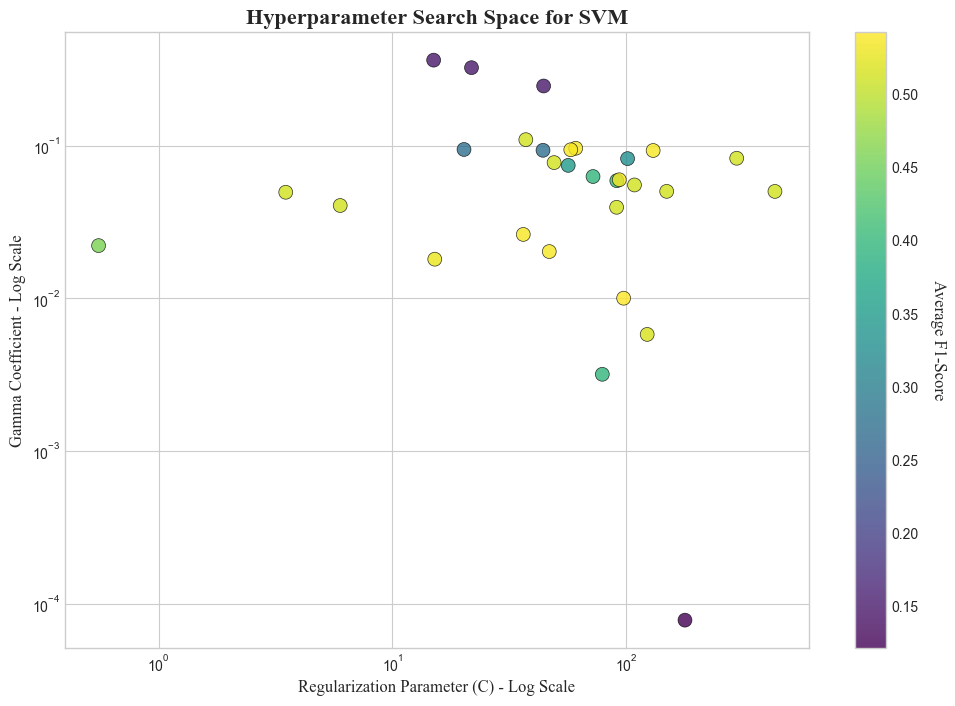

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Asumiendo que 'random_search_svm' es tu objeto RandomizedSearchCV ya entrenado
results_svm = pd.DataFrame(random_search_svm.cv_results_)

# --- Creación de la Gráfica Profesional ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# El gráfico de dispersión
scatter = ax.scatter(
    results_svm['param_base_estimator__C'], 
    results_svm['param_base_estimator__gamma'], 
    c=results_svm['mean_test_f1'], 
    cmap='viridis',  # Paleta de colores: los puntos más brillantes (amarillo) tienen mejor F1-Score
    s=100,           # Tamaño de los puntos
    alpha=0.8,
    edgecolors='k',
    linewidth=0.5
)

# Títulos y etiquetas con fuente profesional
ax.set_title('Hyperparameter Search Space for SVM', fontsize=16, fontname='Times New Roman', weight='bold')
ax.set_xlabel('Regularization Parameter (C) - Log Scale', fontsize=12, fontname='Times New Roman')
ax.set_ylabel('Gamma Coefficient - Log Scale', fontsize=12, fontname='Times New Roman')

# Usamos escala logarítmica para una mejor visualización de los valores
ax.set_xscale('log')
ax.set_yscale('log')

# Barra de color que funciona como leyenda para el F1-Score
cbar = fig.colorbar(scatter)
cbar.set_label('Average F1-Score', rotation=270, labelpad=20, fontsize=12, fontname='Times New Roman')

plt.show()

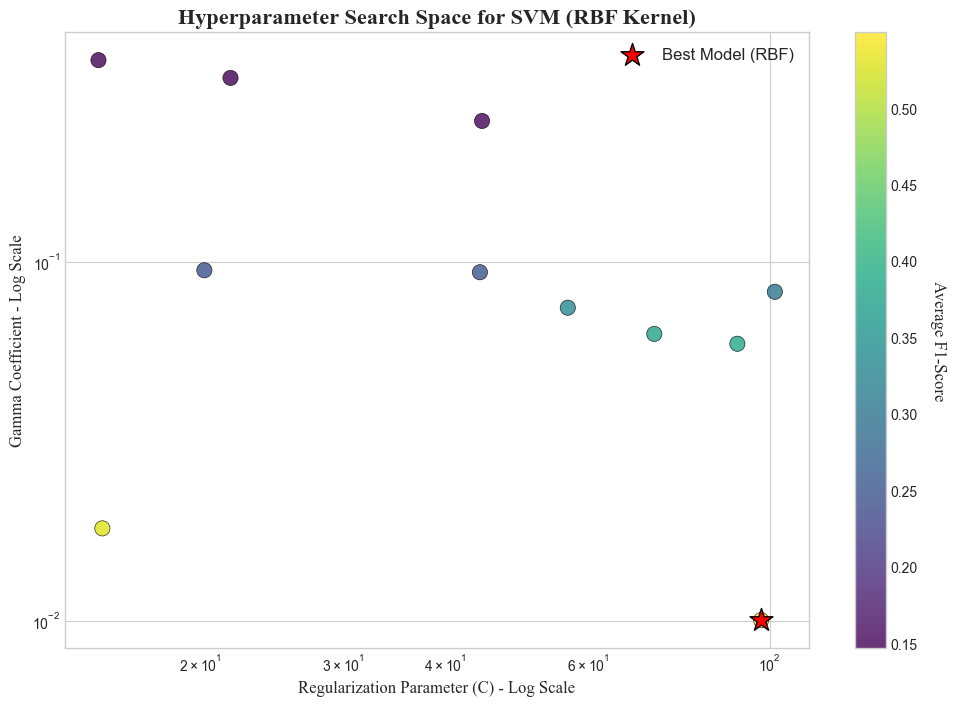

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Asumiendo que 'random_search_svm' es tu objeto RandomizedSearchCV para SVM ya entrenado
results_svm = pd.DataFrame(random_search_svm.cv_results_)

# Filtramos los resultados para visualizar solo los del kernel 'rbf', que es el más común
# y donde 'gamma' es relevante.
results_rbf = results_svm[results_svm['param_base_estimator__kernel'] == 'rbf']

# --- Creación de la Gráfica Profesional (Estilo IJECE) ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# El gráfico de dispersión
# Eje X: Parámetro de Regularización (C), Eje Y: Coeficiente Gamma, Color: F1-Score
scatter = ax.scatter(
    results_rbf['param_base_estimator__C'], 
    results_rbf['param_base_estimator__gamma'], 
    c=results_rbf['mean_test_f1'], 
    cmap='viridis',
    s=120,
    alpha=0.8,
    edgecolors='k',
    linewidth=0.5
)

# Títulos y etiquetas con fuente profesional
ax.set_title('Hyperparameter Search Space for SVM (RBF Kernel)', fontsize=16, fontname='Times New Roman', weight='bold')
ax.set_xlabel('Regularization Parameter (C) - Log Scale', fontsize=12, fontname='Times New Roman')
ax.set_ylabel('Gamma Coefficient - Log Scale', fontsize=12, fontname='Times New Roman')

# Escala logarítmica para mejor visualización
ax.set_xscale('log')
ax.set_yscale('log')

# Barra de color para la leyenda del F1-Score
cbar = fig.colorbar(scatter)
cbar.set_label('Average F1-Score', rotation=270, labelpad=20, fontsize=12, fontname='Times New Roman')

# Marcar el mejor punto encontrado dentro de los resultados del kernel RBF
if not results_rbf.empty:
    best_idx_rbf = results_rbf['mean_test_f1'].idxmax()
    ax.scatter(
        results_rbf['param_base_estimator__C'][best_idx_rbf],
        results_rbf['param_base_estimator__gamma'][best_idx_rbf],
        color='red',
        marker='*',
        s=300,
        edgecolors='black',
        label='Best Model (RBF)'
    )

ax.legend(fontsize=12)
plt.show()

C:\Users\SAUL\AppData\Local\Temp\ipykernel_14240\3495552640.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=error_counts, y=error_descs, palette='viridis', ax=ax)


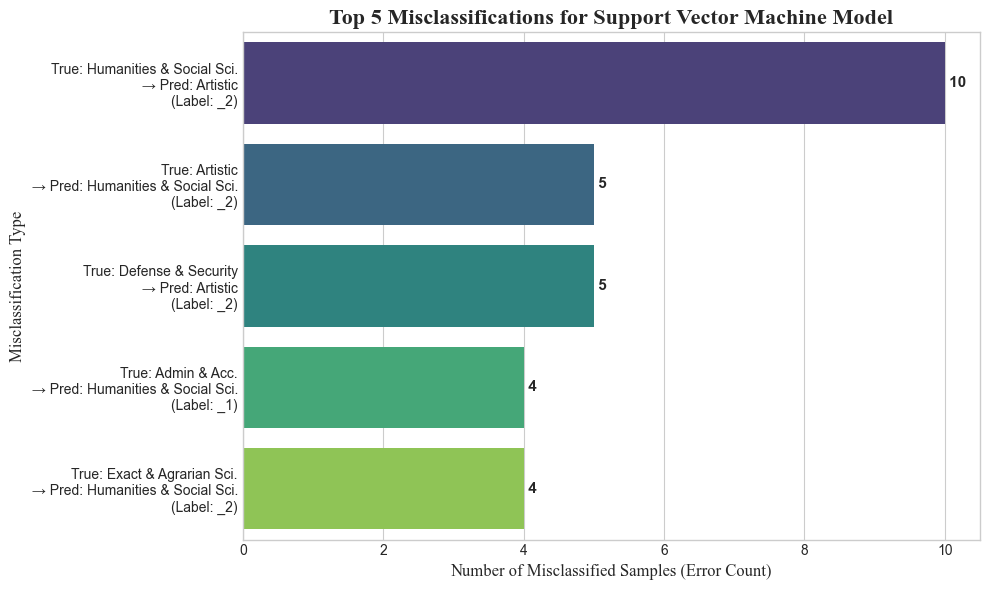

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# ===================================================================
# PREREQUISITES:
# This code assumes the following variables already exist from your previous cells:
# - Y_test: DataFrame with the true labels for the test set.
# - y_pred_df: DataFrame with the predicted labels from the model you are analyzing.
# - encoders: Dictionary of your fitted LabelEncoders.
# ===================================================================

# ===== PASO CLAVE: Diccionario de Traducción (Español a Inglés) =====
translation_map = {
    'Humanísticas y Ciencias Sociales': 'Humanities & Social Sci.',
    'Administrativas y Contables': 'Admin & Acc.',
    'Defensa y Seguridad': 'Defense & Security',
    'Ciencias Exactas y Agrarias': 'Exact & Agrarian Sci.',
    'Ingeniería y Computación': 'Engineering & Computing',
    'Artísticas': 'Artistic',
    'Medicina y ciencias de la Salud': 'Medicine & Health Sci.' 
}
# =====================================================================


# --- 1. Extract All Misclassifications from the Model ---
model_errors = []
for i, col_name in enumerate(Y_test.columns):
    # Asegúrate de que y_pred_df corresponda al modelo que estás analizando
    cm = confusion_matrix(Y_test[col_name], y_pred_svm_df[col_name]) 
    class_names = encoders[col_name].classes_
    
    # Iterar sobre la matriz de confusión para encontrar los errores
    for true_idx in range(len(class_names)):
        for pred_idx in range(len(class_names)):
            if true_idx != pred_idx and cm[true_idx, pred_idx] > 0:
                true_class_spanish = class_names[true_idx]
                pred_class_spanish = class_names[pred_idx]
                error_count = cm[true_idx, pred_idx]
                
                # ===== Usamos el diccionario para traducir los nombres =====
                true_class_english = translation_map.get(true_class_spanish, true_class_spanish)
                pred_class_english = translation_map.get(pred_class_spanish, pred_class_spanish)
                
                # Formatear la descripción del error con los nombres en inglés
                error_description = f"True: {true_class_english}\n→ Pred: {pred_class_english}\n(Label: {col_name[-9:-7]})"
                model_errors.append((error_count, error_description))

# --- 2. Preparar los datos para la gráfica ---
# Ordenar los errores por frecuencia y obtener el Top 5
model_errors.sort(key=lambda x: x[0], reverse=True)
top_5_errors = model_errors[:5]

# Separar conteos y descripciones para graficar
error_counts = [count for count, desc in top_5_errors]
error_descs = [desc for count, desc in top_5_errors]

# --- 3. Generar el Gráfico de Barras ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

# Crear el gráfico de barras horizontales
sns.barplot(x=error_counts, y=error_descs, palette='viridis', ax=ax)

# Títulos y etiquetas en inglés
ax.set_title('Top 5 Misclassifications for Support Vector Machine Model', fontsize=16, fontname='Times New Roman', weight='bold')
ax.set_xlabel('Number of Misclassified Samples (Error Count)', fontsize=12, fontname='Times New Roman')
ax.set_ylabel('Misclassification Type', fontsize=12, fontname='Times New Roman')

# Añadir el conteo al final de cada barra para mayor claridad
for index, value in enumerate(error_counts):
    ax.text(value, index, f' {value}', va='center', fontsize=11, weight='bold')

plt.tight_layout()
plt.show()

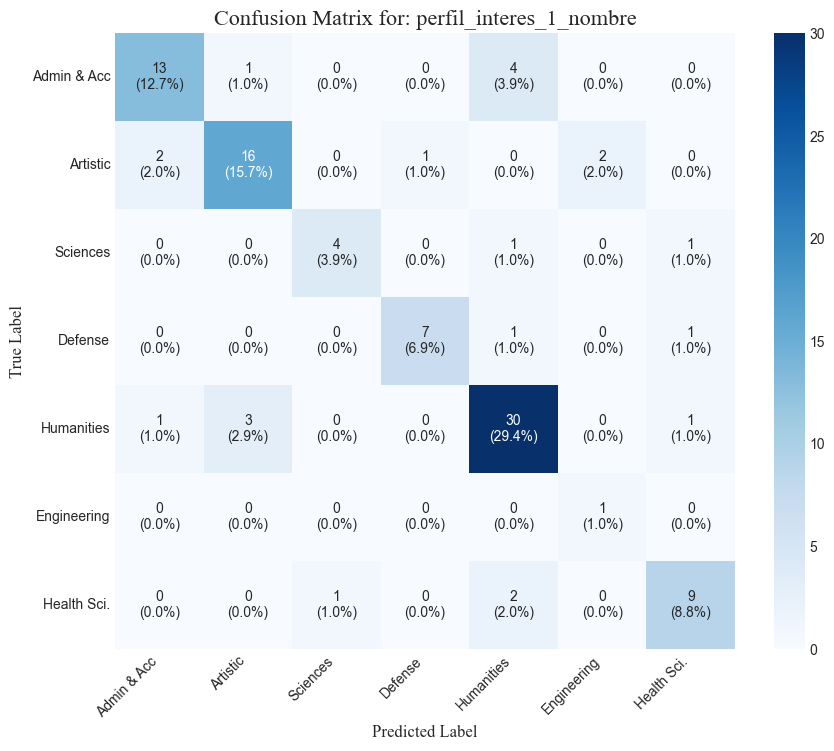

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# ===================================================================
# PREREQUISITES:
# This code assumes the following variables already exist from your previous cells:
# - Y_test: DataFrame with the true labels for the test set.
# - y_pred_df: DataFrame with the predicted labels from your model.
# - encoders: Dictionary of your fitted LabelEncoders.
# ===================================================================

# --- CONFIGURATION: CHANGE THIS NUMBER FOR EACH LABEL (0, 1, 2, or 3) ---
LABEL_TO_PLOT = 0
# --------------------------------------------------------------------

# Select the specified label to plot
column_to_plot = Y_test.columns[LABEL_TO_PLOT]
true_labels = Y_test[column_to_plot]
pred_labels = y_pred_svm_df[column_to_plot]

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
class_names = encoders[column_to_plot].classes_

# Abbreviation map for cleaner labels
abbreviation_map = {
    'Humanísticas y Ciencias Sociales': 'Humanities',
    'Administrativas y Contables': 'Admin & Acc',
    'Defensa y Seguridad': 'Defense',
    'Ciencias Exactas y Agrarias': 'Sciences',
    'Ingeniería y Computación': 'Engineering',
    'Artísticas': 'Artistic',
    'Medicina y Ciencias de la Salud': 'Health Sci.'
}
abbreviated_names = [abbreviation_map.get(name, name) for name in class_names]

# Create custom annotations (count and percentage)
group_counts = [f"{value}" for value in cm.flatten()]
total_samples = np.sum(cm)
group_percentages = [f"{value/total_samples:.1%}" for value in cm.flatten()]
annotations = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
annotations = np.asarray(annotations).reshape(cm.shape)

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues',
            xticklabels=abbreviated_names, yticklabels=abbreviated_names, cbar=True)

plt.title(f'Confusion Matrix for: {column_to_plot}', fontsize=16, fontname='Times New Roman')
plt.ylabel('True Label', fontsize=12, fontname='Times New Roman')
plt.xlabel('Predicted Label', fontsize=12, fontname='Times New Roman')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()